In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline  
#plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn')


In [2]:
data_path = r"C:\\Users\\Armin\\Documents\\Code\\Studienarbeit\\crypto_daten_kaggle\\"
crypto_df = pd.read_hdf('train.h5')
crypto_df.head(5)

FileNotFoundError: File train.h5 does not exist

In [ ]:
btc = crypto_df[crypto_df["Asset_ID"]==1]
btc["timestamp"] = pd.to_datetime(btc["timestamp"], unit='s')
btc.set_index("timestamp",inplace=True)

C:\Users\Armin\AppData\Local\Temp/ipykernel_20284/3700651095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc["timestamp"] = pd.to_datetime(btc["timestamp"], unit='s')


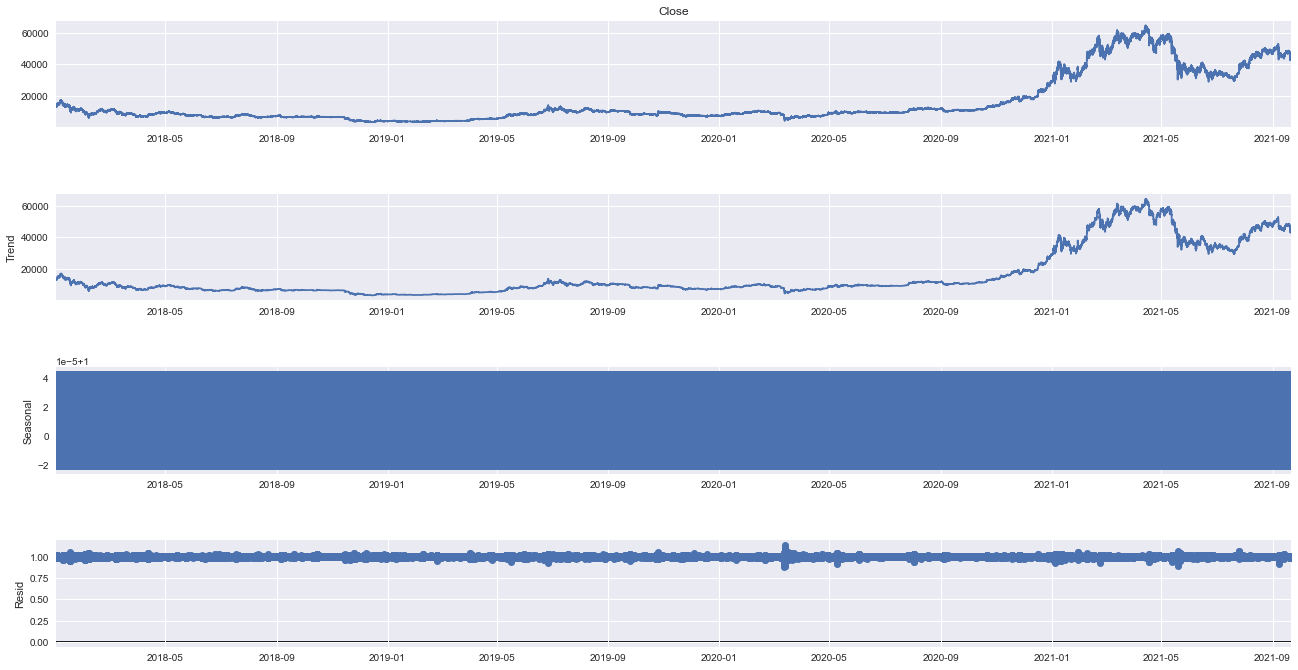

In [ ]:

result=seasonal_decompose(btc['Close'], model='multiplicative', period=60)
fig = result.plot()
fig.set_size_inches(20,10)

In [ ]:
btc["MA"] = btc["Close"].rolling(200).mean()
result=seasonal_decompose(np.log(btc['Close']), model='additive', period=60)

C:\Users\Armin\AppData\Local\Temp/ipykernel_20284/4168880489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc["MA"] = btc["Close"].rolling(200).mean()


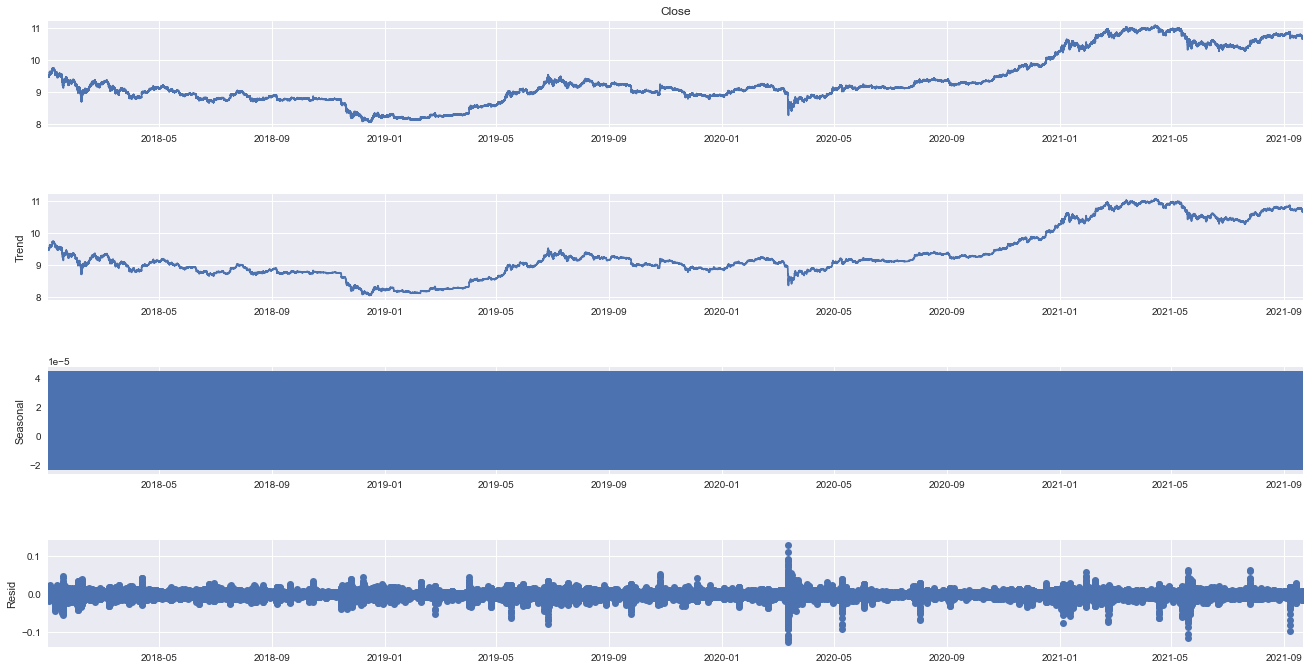

In [ ]:
fig = result.plot()
fig.set_size_inches(20,10)

In [ ]:
resid = result.resid
print(resid.dropna())

timestamp
2018-01-01 00:31:00   -0.000287
2018-01-01 00:32:00    0.000724
2018-01-01 00:33:00    0.001335
2018-01-01 00:34:00   -0.000224
2018-01-01 00:35:00    0.001148
                         ...   
2021-09-20 23:26:00   -0.004284
2021-09-20 23:27:00   -0.004113
2021-09-20 23:28:00   -0.005784
2021-09-20 23:29:00   -0.006597
2021-09-20 23:30:00   -0.007869
Name: resid, Length: 1956222, dtype: float64


## FFT

In [ ]:
close_fft = np.fft.fft(np.asarray(btc['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

c:\Users\Armin\Documents\Code\Studienarbeit\Analyse_01\env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\Armin\Documents\Code\Studienarbeit\Analyse_01\env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\Armin\Documents\Code\Studienarbeit\Analyse_01\env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\Armin\Documents\Code\Studienarbeit\Analyse_01\env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


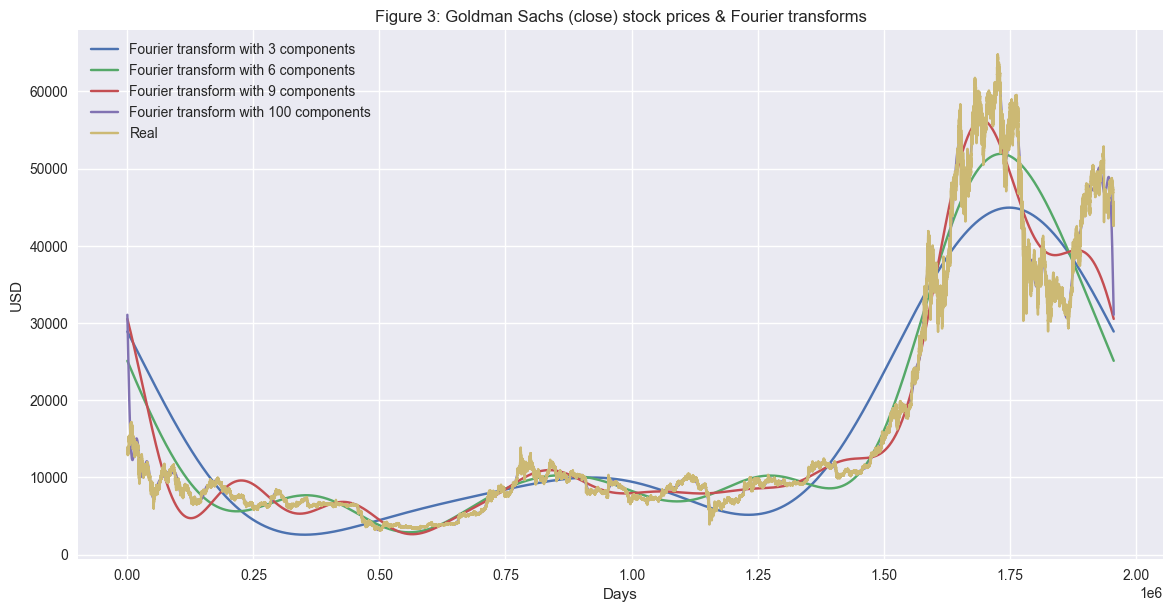

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(btc['Close'].tolist(),  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

### Wavelets

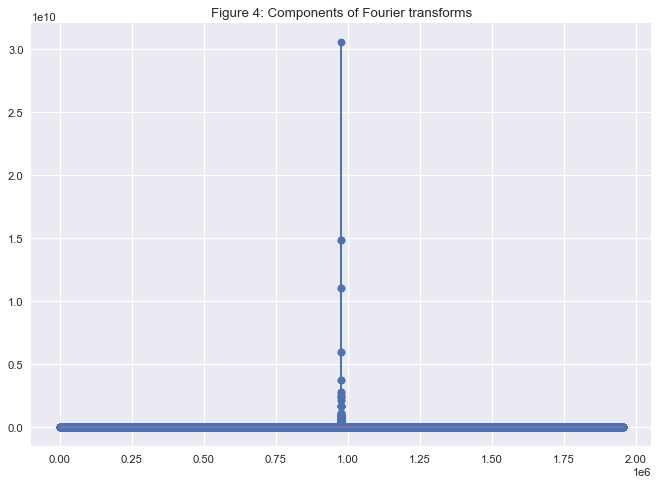

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## Short time fourier transformation

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
close_scaled = scaler.fit_transform(btc)[:,7]

#plt.plot(close_scaled)

In [ ]:
print(close_scaled.shape)

(1956282,)


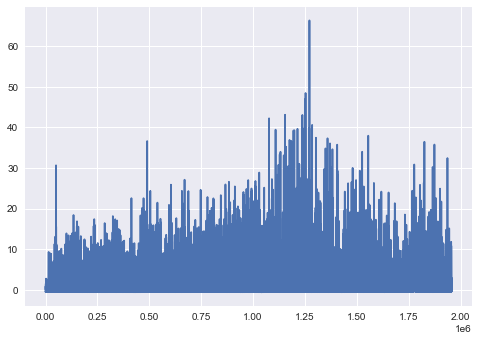

In [ ]:
plt.plot(close_scaled)

C:\Users\Armin\AppData\Local\Temp/ipykernel_20284/2559304284.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(t, f, np.abs(Zxx), cmap=plt.get_cmap('RdYlGn'))


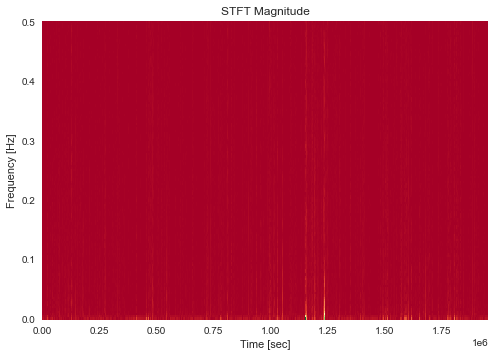

In [ ]:
f, t, Zxx = signal.stft(close_scaled,fs=1,window='hann')
plt.pcolormesh(t, f, np.abs(Zxx), cmap=plt.get_cmap('RdYlGn'))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

C:\Users\Armin\AppData\Local\Temp/ipykernel_20284/3832101762.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


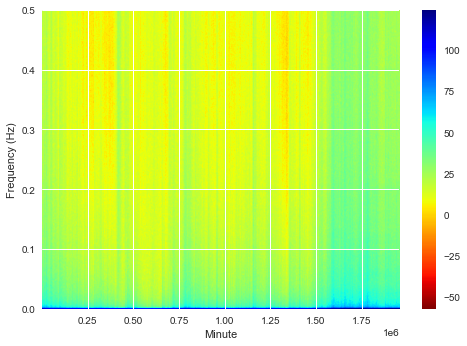

In [ ]:
plt.specgram(btc["Close"], NFFT=1000, Fs=1, noverlap=500, cmap='jet_r', mode='psd')
plt.colorbar()
plt.xlabel("Minute")
plt.ylabel("Frequency (Hz)")
plt.show()

## Rolling statistics

In [ ]:
btc["std_kurz"] = btc["Close"].rolling(60).std()
btc["mean_kurz"] = btc["Close"].rolling(60).mean()

btc["std_lang"] = btc["Close"].rolling(1440).std()
btc["mean_lang"] = btc["Close"].rolling(1440).mean()

btc['Bollinger_High_classic'] = btc["mean_kurz"] + (btc["std_kurz"] * 2)
btc['Bollinger_Low_classic'] = btc["mean_kurz"] - (btc["std_kurz"] * 2) 

btc['Bollinger_High_urban'] = btc["mean_kurz"] + (btc["std_kurz"] * 3.5)
btc['Bollinger_Low_urban'] = btc["mean_kurz"] - (btc["std_kurz"] * 0.5)      

C:\Users\Armin\AppData\Local\Temp/ipykernel_20284/491499853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc["std_kurz"] = btc["Close"].rolling(60).std()
C:\Users\Armin\AppData\Local\Temp/ipykernel_20284/491499853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc["mean_kurz"] = btc["Close"].rolling(60).mean()
C:\Users\Armin\AppData\Local\Temp/ipykernel_20284/491499853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [ ]:
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['High'] - df_feat['Low']
    df_feat['mean_trade'] = df_feat['Volume']/df_feat['Count']
    df_feat['log_price_change'] = np.log(df_feat['Close']/df_feat['Open'])
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat['trade'] = df_feat['Close'] - df_feat['Open']
    df_feat['gtrade'] = df_feat['trade'] / df_feat['Count']
    df_feat['shadow1'] = df_feat['trade'] / df_feat['Volume']
    df_feat['shadow3'] = df_feat['upper_Shadow'] / df_feat['Volume']
    df_feat['shadow5'] = df_feat['lower_Shadow'] / df_feat['Volume']
    df_feat['diff1'] = df_feat['Volume'] - df_feat['Count']
    df_feat['mean1'] = (df_feat['shadow5'] + df_feat['shadow3']) / 2
    df_feat['mean2'] = (df_feat['shadow1'] + df_feat['Volume']) / 2
    df_feat['mean3'] = (df_feat['trade'] + df_feat['gtrade']) / 2
    df_feat['mean4'] = (df_feat['diff1'] + df_feat['upper_Shadow']) / 2
    df_feat['mean5'] = (df_feat['diff1'] + df_feat['lower_Shadow']) / 2
    df_feat['UPS'] = (df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open']))
    df_feat['UPS'] = df_feat['UPS']
    df_feat['LOS'] = (np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low'])
    df_feat['LOS'] = df_feat['LOS']
    df_feat['RNG'] = ((df_feat['High'] - df_feat['Low']) / df_feat['VWAP'])
    df_feat['RNG'] = df_feat['RNG']
    df_feat['MOV'] = ((df_feat['Close'] - df_feat['Open']) / df_feat['VWAP'])
    df_feat['MOV'] = df_feat['MOV']
    df_feat['CLS'] = ((df_feat['Close'] - df_feat['VWAP']) / df_feat['VWAP'])
    df_feat['CLS'] = df_feat['CLS']
    df_feat['LOGVOL'] = np.log(1. + df_feat['Volume'])
    df_feat['LOGVOL'] = df_feat['LOGVOL']
    df_feat['LOGCNT'] = np.log(1. + df_feat['Count'])
    df_feat['LOGCNT'] = df_feat['LOGCNT']
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"]
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"]
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"]
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
    if row: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean()
    else: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
    df_feat["High/Mean"] = df_feat["High"] / df_feat["Mean"]
    df_feat["Low/Mean"] = df_feat["Low"] / df_feat["Mean"]
    df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)
    mean_price = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df_feat[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df_feat['high2mean'] = df_feat['High'] / mean_price
    df_feat['low2mean'] = df_feat['Low'] / mean_price
    df_feat['high2median'] = df_feat['High'] / median_price
    df_feat['low2median'] = df_feat['Low'] / median_price
    df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    return df_feat

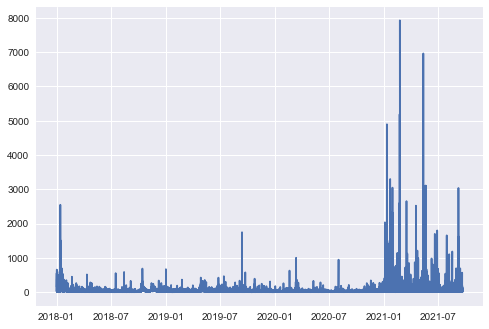

In [ ]:
plt.plot(upper_shadow(btc))

## Technische Analyse

In [ ]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    print(macd)
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

In [ ]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

In [ ]:
btc = btc.join(get_macd(btc['Close'], 26, 12, 9))

                          macd
timestamp                     
2018-01-01 00:01:00   0.000000
2018-01-01 00:02:00  -1.760889
2018-01-01 00:03:00  -5.257370
2018-01-01 00:04:00 -10.591202
2018-01-01 00:05:00 -18.089683
...                        ...
2021-09-20 23:56:00  31.173370
2021-09-20 23:57:00  26.224115
2021-09-20 23:58:00  19.416305
2021-09-20 23:59:00  29.038489
2021-09-21 00:00:00  35.067911

[1956282 rows x 1 columns]


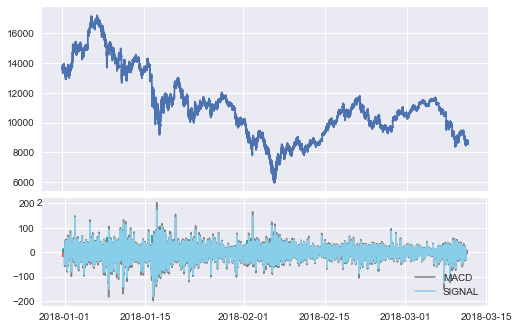

In [ ]:
btc_short = btc.head(100000)
plot_macd(btc_short['Close'], btc_short['macd'], btc_short['signal'], btc_short['hist'])

In [ ]:
btc["MA"] = btc.Close.rolling(window=20).mean()
btc["MA_diff"] = btc.MA - btc.Close

In [ ]:
#Relative Strength Index
def RSI(df, n):
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= len(df) - 1:
        UpMove = get_value(df, i + 1, 'High') - get_value(df, i, 'High')
        DoMove = get_value(df, i, 'Low') - get_value(df, i + 1, 'Low')
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else: UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else: DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(ewma(UpI, span = n, min_periods = n - 1))
    NegDI = pd.Series(ewma(DoI, span = n, min_periods = n - 1))
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))
    df['RSI'] = RSI
    return df

## Outlier correction

In [ ]:
btc["log_close"] = np.log(1+(btc["Close"]-btc["Close"].shift(1))/btc["Close"].shift(1))
btc.head

<bound method NDFrame.head of                         index  Asset_ID   Count          Open          High  \
timestamp                                                                     
2018-01-01 00:01:00         2         1   229.0  13835.194000  14013.800000   
2018-01-01 00:02:00        10         1   235.0  13835.036000  14052.300000   
2018-01-01 00:03:00        18         1   528.0  13823.900000  14000.400000   
2018-01-01 00:04:00        26         1   435.0  13802.512000  13999.000000   
2018-01-01 00:05:00        34         1   742.0  13766.000000  13955.900000   
...                       ...       ...     ...           ...           ...   
2021-09-20 23:56:00  24236739         1  1940.0  42983.780000  43001.850849   
2021-09-20 23:57:00  24236753         1  2026.0  42904.197143  42932.000000   
2021-09-20 23:58:00  24236767         1  1986.0  42859.385714  42887.500000   
2021-09-20 23:59:00  24236781         1  4047.0  42839.012802  43042.160000   
2021-09-21 00:00:00  2

<AxesSubplot:>

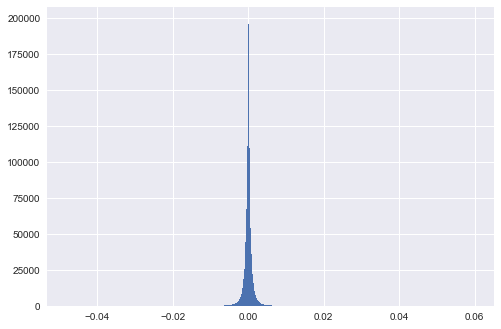

In [ ]:
btc_logs = btc["log_close"]
btc_logs.hist(bins = 1000)

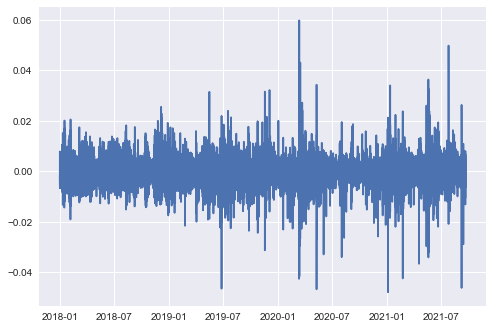

In [ ]:
plt.plot(btc_logs)

In [ ]:
#https://github.com/krishnaik06/Finding-an-Outlier/blob/master/Finding%20an%20outlier%20in%20a%20Dataset.ipynb
def detect_outliers(data,row_name):  
    threshold=30
    mean = np.mean(data[row_name])
    std =np.std(data[row_name])
    counter = 0
    for index, row in data.iterrows():
        if not (row[row_name] != row[row_name]):
            z_score = (row[row_name] - mean)/std 
            if z_score > threshold:
                data.at[index, row_name] = (threshold*std)+mean
                counter += 1
            elif z_score < threshold*-1:
                data.at[index, row_name] = (-1*threshold*std)+mean
                counter += 1
    print(counter)
    return data
            
            

19


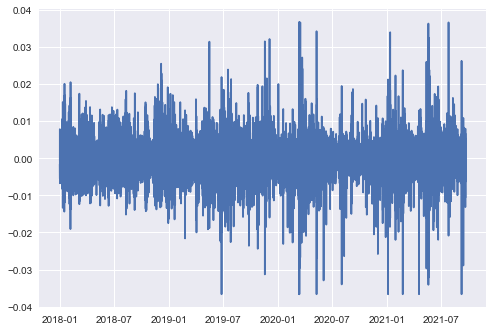

In [ ]:
detect_outliers(btc,"log_close")
plt.plot(btc["log_close"])

In [ ]:
print(btc["log_close"])

timestamp
2018-01-01 00:01:00         NaN
2018-01-01 00:02:00   -0.001595
2018-01-01 00:03:00   -0.001939
2018-01-01 00:04:00   -0.002414
2018-01-01 00:05:00   -0.003137
                         ...   
2021-09-20 23:56:00   -0.002007
2021-09-20 23:57:00   -0.000910
2021-09-20 23:58:00   -0.000770
2021-09-20 23:59:00    0.004433
2021-09-21 00:00:00   -0.000343
Name: log_close, Length: 1956282, dtype: float64


In [ ]:
btc_filterd = btc.loc['2020-01-01':'2020-02-01']

In [ ]:
btc_filterd.head()

,index,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,mean_lang,Bollinger_High_classic,Bollinger_Low_classic,Bollinger_High_urban,Bollinger_Low_urban,macd,signal,hist,MA_diff,log_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:01:00,12007911,1,473.0,7178.211429,7200.000000,7151.92,7176.200000,43.964876,7177.022443,-0.000145,...,7214.973008,7194.940042,7176.194863,7201.969485,7183.224305,-0.071895,1.280984,-1.352878,11.683099,-0.001266
2020-01-01 00:02:00,12007923,1,442.0,7176.064286,7200.038592,7155.00,7175.011227,24.181929,7175.190824,-0.000214,...,7214.953256,7194.746300,7175.755407,7201.867885,7182.876992,-0.977209,0.829345,-1.806554,12.350850,-0.000166
2020-01-01 00:03:00,12007935,1,329.0,7175.668571,7200.000000,7156.13,7177.224286,15.939591,7176.132579,0.000111,...,7214.937100,7194.508626,7175.478447,7201.644943,7182.614764,-1.498824,0.363711,-1.862535,9.737434,0.000308
2020-01-01 00:04:00,12007947,1,373.0,7176.617143,7200.000000,7154.97,7173.358571,27.399868,7173.982407,-0.000592,...,7214.914763,7194.773434,7174.818258,7202.256625,7182.301449,-2.198793,-0.148790,-2.050003,12.931506,-0.000539
2020-01-01 00:05:00,12007959,1,514.0,7173.408571,7199.028800,7136.05,7172.134286,104.204231,7170.915375,0.000206,...,7214.895537,7195.067285,7174.074930,7202.939419,7181.947063,-2.819807,-0.682993,-2.136814,13.392089,-0.000171


In [ ]:
index = btc_filterd.index
len(index)

46078

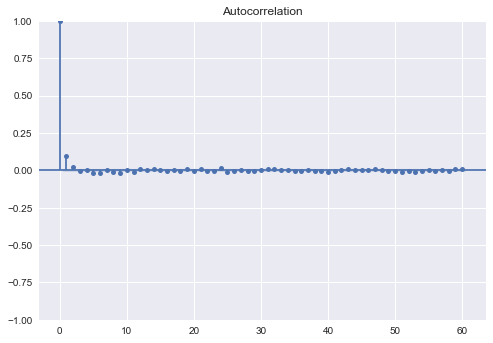

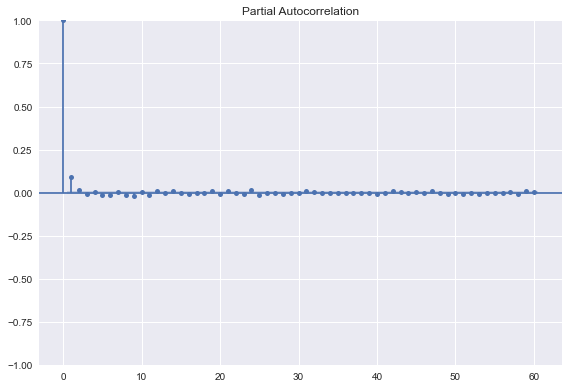

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(btc_filterd['log_close'],lags=60)
sm.graphics.tsa.plot_pacf(btc_filterd['log_close'],lags=60, method='ols')


plt.tight_layout()
plt.show()

In [ ]:
btc["perf"] = (btc["Close"]-btc["Close"].shift(1))/btc["Close"].shift(1)
btc_season = btc["perf"]

## Month

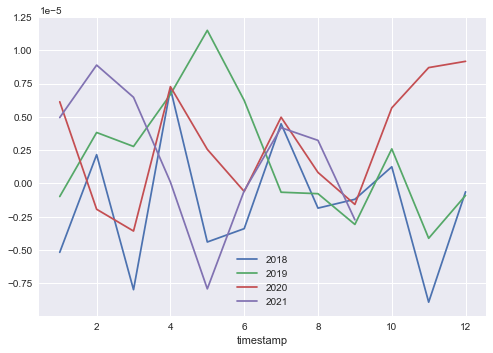

In [ ]:
fig, ax = plt.subplots()
years_list = []
for i in range(0,4):
    year = 2018 + i
    btc_season = btc["perf"]
    btc_season = btc_season.loc[ str(year) +'-01-01':str(year)+'-12-31']
    btc_season.groupby(btc_season.index.month).mean().plot()
    years_list.append(year)
ax.legend(years_list) 

## Day

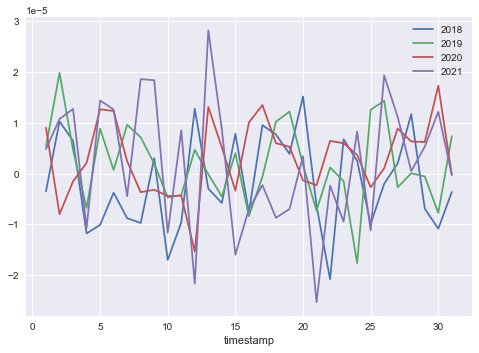

In [ ]:
fig, ax = plt.subplots()
for i in range(0,4):
    year = 2018 + i
    btc_season = btc["perf"]
    btc_season = btc_season.loc[ str(year) +'-01-01':str(year)+'-12-31']
    btc_season.groupby(btc_season.index.day).mean().plot()
ax.legend(years_list) 


## Hour

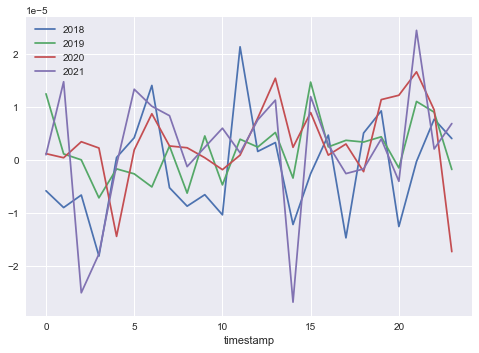

In [ ]:
fig, ax = plt.subplots()
for i in range(0,4):
    year = 2018 + i
    btc_season = btc["perf"]
    btc_season = btc_season.loc[ str(year) +'-01-01':str(year)+'-12-31']
    btc_season.groupby(btc_season.index.hour).mean().plot()
ax.legend(years_list)

## Minute

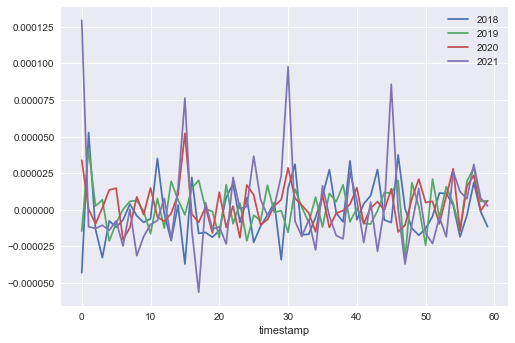

In [ ]:
fig, ax = plt.subplots()
for i in range(0,4):
    year = 2018 + i
    btc_season = btc["perf"]
    btc_season = btc_season.loc[ str(year) +'-01-01':str(year)+'-12-31']
    btc_season.groupby(btc_season.index.minute).mean().plot()
ax.legend(years_list)

<AxesSubplot:xlabel='timestamp'>

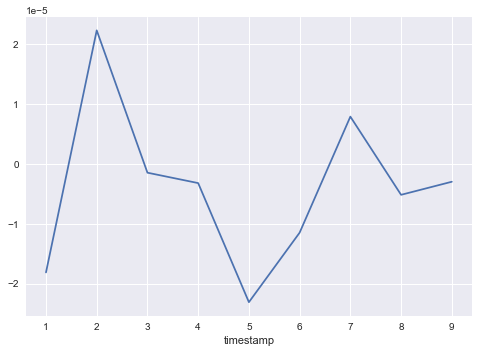

In [ ]:
btc_season.groupby(btc_season.index.month).median().plot()

<AxesSubplot:xlabel='timestamp'>

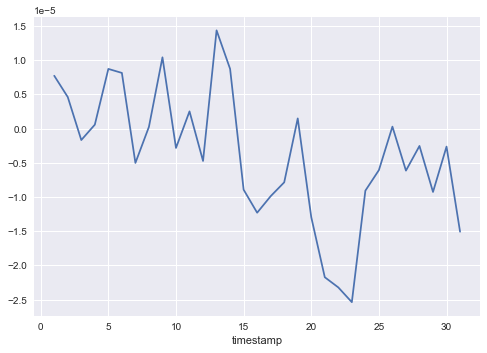

In [ ]:
btc_season.groupby(btc_season.index.day).median().plot()

<AxesSubplot:xlabel='timestamp'>

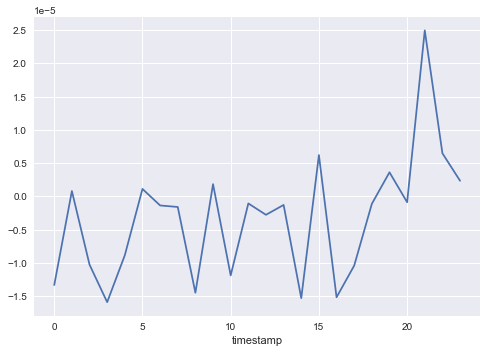

In [ ]:
btc_season.groupby(btc_season.index.hour).median().plot()

<AxesSubplot:xlabel='timestamp'>

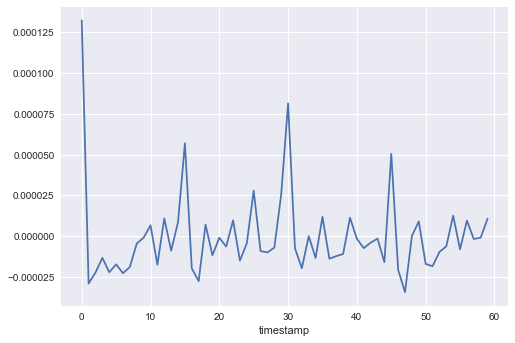

In [ ]:
btc_season.groupby(btc_season.index.minute).median().plot()

In [ ]:
btc["Minute"] = btc.index.minute
btc["Day"] = btc.index.day
btc["Month"] = btc.index.month
btc["Year"] = btc.index.year
btc["DayOfWeek"] = btc.index.dayofweek

In [ ]:
btc_season_log = btc["log_close"]

<AxesSubplot:xlabel='timestamp'>

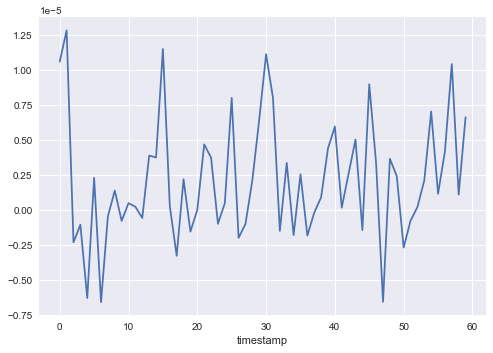

In [ ]:
btc_season_log.groupby(btc_season_log.index.minute).median().plot()

<AxesSubplot:xlabel='timestamp'>

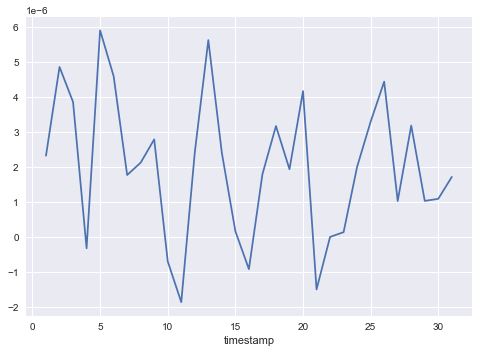

In [ ]:
btc_season_log.groupby(btc_season_log.index.day).median().plot()

In [ ]:
CORR_VALS = btc_season_log.groupby(btc_season_log.index.minute).median()
btc["minute_Seasonal"] = btc.Minute.apply(min_mapper, pd_series = CORR_VALS)

In [ ]:
diff_seasonal_min = np.diff(CORR_VALS)/0.1

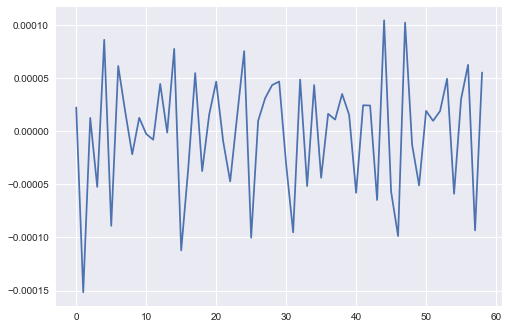

In [ ]:
plt.plot(diff_seasonal_min)

In [ ]:

def min_mapper(value,pd_series):
    return pd_series.loc[value]

In [ ]:
from scipy.stats import pearsonr 
def get_correlation(vals):
    return pearsonr(vals, CORR_VALS)[0]

btc['correlation_log_perf'] = btc_season_log.rolling(window=len(CORR_VALS)).apply(get_correlation)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6, 6))


<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>